In [432]:
import os 
import sys
import time
import datetime
import collections
import itertools
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import scipy as sci

import matplotlib.pyplot as plt

In [341]:
train_part = pd.read_csv('alfabattle2_abattle_train_target.csv', parse_dates=['timestamp'])
train_part.drop(columns=['session_id'], inplace=True)
print(train_part.shape)
train_part.head(3)

(5065350, 3)


,client_pin,timestamp,multi_class_target
0,7cf9221322a0e2fdefb1b998b8f2ab29,2020-06-15 14:01:12,main_screen
1,5f16c0ab27a806fd08db3122921adf3a,2020-03-21 12:59:34,invest
2,ec868fc2b388293cf10e18ee9518d72f,2020-01-24 18:18:55,statement


In [342]:
test_part = pd.read_csv('alfabattle2_prediction_session_timestamp.csv', parse_dates=['timestamp'])
test_part['multi_class_target'] = 'need_to_predict'
print(test_part.shape)
test_part.head(3)

(79268, 3)


,client_pin,timestamp,multi_class_target
0,f0c674b2bb4dc64be607029271d706ec,2020-08-01 00:00:53,need_to_predict
1,90725b54ce77576883813d87749df6bd,2020-08-01 00:02:57,need_to_predict
2,eb0f82d74c7b7bd5eafbd5b5f8cb3e2a,2020-08-01 00:03:14,need_to_predict


In [343]:
sample_sub = pd.read_csv('alfabattle2_abattle_sample_prediction.csv')
print(sample_sub.shape)
sample_sub.head(3)

(79268, 2)


,client_pin,prediction
0,f0c674b2bb4dc64be607029271d706ec,credit_info
1,90725b54ce77576883813d87749df6bd,credit_info
2,eb0f82d74c7b7bd5eafbd5b5f8cb3e2a,own_transfer


### EDA

In [351]:
train_part.client_pin.value_counts().describe(percentiles=[.05, .10, .15, 0.20, 0.25, 0.3])

count    79268.000000
mean        63.901574
std         85.280433
min          1.000000
5%           3.000000
10%          5.000000
15%          8.000000
20%         11.000000
25%         14.000000
30%         17.000000
50%         35.000000
max       1646.000000
Name: client_pin, dtype: float64

In [345]:
train_part.multi_class_target.value_counts()

main_screen             2280763
statement                922569
credit_info              498698
own_transfer             290077
mobile_recharge          266485
phone_money_transfer     232911
card2card_transfer       193378
chat                     184775
card_recharge            138616
invest                    57078
Name: multi_class_target, dtype: int64

### Concatanation

In [433]:
train_part.multi_class_target.unique()

array(['main_screen', 'invest', 'statement', 'phone_money_transfer',
       'own_transfer', 'credit_info', 'chat', 'card2card_transfer',
       'mobile_recharge', 'card_recharge'], dtype=object)

In [434]:
Xy = pd.concat([train_part, test_part], axis=0).sort_values(['client_pin', 'timestamp'], ascending=[True, True])
Xy.reset_index(inplace=True, drop=True)
print(Xy.shape)
Xy.head(3)

(5144618, 3)


,client_pin,timestamp,multi_class_target
0,000033b6509acd1c8eb0d06ebd2e1de9,2020-02-02 22:31:04,statement
1,000033b6509acd1c8eb0d06ebd2e1de9,2020-02-19 18:37:26,main_screen
2,000033b6509acd1c8eb0d06ebd2e1de9,2020-02-22 23:18:45,main_screen


### Feature engineering

In [435]:
for k in range(1, 11, 1):
    print(k)
    Xy.loc[:, f'target_lag_{k}'] = Xy.groupby(['client_pin'])['multi_class_target'].shift(k)
    Xy.loc[:, f'time_diff_{k}'] = Xy.groupby(['client_pin'])['timestamp'].diff(k).astype('timedelta64[s]')

1
2
3
4
5
6
7
8
9
10


In [436]:
lala = Xy[Xy.client_pin == '000033b6509acd1c8eb0d06ebd2e1de9']

In [444]:
lala.head()

,client_pin,timestamp,multi_class_target,target_lag_1,time_diff_1,target_lag_2,time_diff_2,target_lag_3,time_diff_3,target_lag_4,...,target_lag_6,time_diff_6,target_lag_7,time_diff_7,target_lag_8,time_diff_8,target_lag_9,time_diff_9,target_lag_10,time_diff_10
0,000033b6509acd1c8eb0d06ebd2e1de9,2020-02-02 22:31:04,statement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000033b6509acd1c8eb0d06ebd2e1de9,2020-02-19 18:37:26,main_screen,statement,1454782.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000033b6509acd1c8eb0d06ebd2e1de9,2020-02-22 23:18:45,main_screen,main_screen,276079.0,statement,1730861.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000033b6509acd1c8eb0d06ebd2e1de9,2020-02-27 17:29:57,main_screen,main_screen,411072.0,main_screen,687151.0,statement,2141933.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000033b6509acd1c8eb0d06ebd2e1de9,2020-03-04 22:39:45,main_screen,main_screen,536988.0,main_screen,948060.0,main_screen,1224139.0,statement,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [447]:
(lala.loc[(lala.iloc[-1, 1] - lala.timestamp) < pd.Timedelta(value=31, unit='days'), 
          'multi_class_target'] == 'mobile_recharge').any()

False

In [360]:
%%time
Xy_cleaned = Xy.groupby('client_pin').apply(lambda group: group.iloc[8:, 1:] \
                                            if group.shape[0] >= 9 else group.iloc[:, 1:]
                                           ).reset_index().drop(columns=['level_1'])
print(Xy_cleaned.shape)
Xy_cleaned.head(3)

(4598578, 19)
CPU times: user 2min 55s, sys: 8.13 s, total: 3min 3s
Wall time: 3min 3s


,client_pin,timestamp,multi_class_target,target_lag_1,time_diff_1,target_lag_2,time_diff_2,target_lag_3,time_diff_3,target_lag_4,time_diff_4,target_lag_5,time_diff_5,target_lag_6,time_diff_6,target_lag_7,time_diff_7,target_lag_8,time_diff_8
0,000033b6509acd1c8eb0d06ebd2e1de9,2020-03-10 18:17:27,main_screen,main_screen,110837.0,main_screen,262795.0,main_screen,376670.0,main_screen,502662.0,main_screen,1039650.0,main_screen,1450722.0,main_screen,1726801.0,statement,3181583.0
1,000033b6509acd1c8eb0d06ebd2e1de9,2020-03-12 15:07:50,main_screen,main_screen,161423.0,main_screen,272260.0,main_screen,424218.0,main_screen,538093.0,main_screen,664085.0,main_screen,1201073.0,main_screen,1612145.0,main_screen,1888224.0
2,000033b6509acd1c8eb0d06ebd2e1de9,2020-03-12 17:19:50,main_screen,main_screen,7920.0,main_screen,169343.0,main_screen,280180.0,main_screen,432138.0,main_screen,546013.0,main_screen,672005.0,main_screen,1208993.0,main_screen,1620065.0


In [361]:
Xy_cleaned.loc[:, 'hour'] = Xy_cleaned.timestamp.dt.hour
Xy_cleaned.loc[:, 'day'] = Xy_cleaned.timestamp.dt.day

In [363]:
Xy_cleaned.drop(columns=['timestamp'], inplace=True)
Xy_cleaned.head(3)

,client_pin,multi_class_target,target_lag_1,time_diff_1,target_lag_2,time_diff_2,target_lag_3,time_diff_3,target_lag_4,time_diff_4,target_lag_5,time_diff_5,target_lag_6,time_diff_6,target_lag_7,time_diff_7,target_lag_8,time_diff_8,hour,day
0,000033b6509acd1c8eb0d06ebd2e1de9,main_screen,main_screen,110837.0,main_screen,262795.0,main_screen,376670.0,main_screen,502662.0,main_screen,1039650.0,main_screen,1450722.0,main_screen,1726801.0,statement,3181583.0,18,10
1,000033b6509acd1c8eb0d06ebd2e1de9,main_screen,main_screen,161423.0,main_screen,272260.0,main_screen,424218.0,main_screen,538093.0,main_screen,664085.0,main_screen,1201073.0,main_screen,1612145.0,main_screen,1888224.0,15,12
2,000033b6509acd1c8eb0d06ebd2e1de9,main_screen,main_screen,7920.0,main_screen,169343.0,main_screen,280180.0,main_screen,432138.0,main_screen,546013.0,main_screen,672005.0,main_screen,1208993.0,main_screen,1620065.0,17,12


In [379]:
Xy_cleaned_train_val = Xy_cleaned.groupby('client_pin').apply(lambda group: group.iloc[:-1, 1:]).reset_index()
Xy_cleaned_train_val.drop(columns=['level_1'], inplace=True)

Xy_cleaned_train = Xy_cleaned.groupby('client_pin').apply(lambda group: group.iloc[:-2, 1:]).reset_index()
Xy_cleaned_train.drop(columns=['level_1'], inplace=True)

Xy_cleaned_val = Xy_cleaned.groupby('client_pin').apply(lambda group: group.iloc[-2, 1:] \
                                                        if group.shape[0] > 1 else None).reset_index()

Xy_cleaned_test = Xy_cleaned.groupby('client_pin').apply(lambda group: group.iloc[-1, 1:]).reset_index()

Xy_cleaned_train_val.shape, Xy_cleaned_train.shape, Xy_cleaned_val.shape, Xy_cleaned_test.shape

((4519310, 20), (4441516, 20), (79268, 20), (79268, 20))

In [385]:
Xy_cleaned_val = Xy_cleaned_val.loc[Xy_cleaned_val.client_pin.isin(Xy_cleaned_train.client_pin.unique())]
Xy_cleaned_val.shape

(74765, 20)

In [387]:
X_train_val, y_train_val = Xy_cleaned_train_val.drop(columns=['multi_class_target']), Xy_cleaned_train_val['multi_class_target']
X_test, y_test = Xy_cleaned_test.drop(columns=['multi_class_target']), Xy_cleaned_test['multi_class_target']

X_train, y_train = Xy_cleaned_train.drop(columns=['multi_class_target']), Xy_cleaned_train['multi_class_target']
X_val, y_val = Xy_cleaned_val.drop(columns=['multi_class_target']), Xy_cleaned_val['multi_class_target']

In [389]:
cat_features = ['client_pin'] + [f'target_lag_{k}' for k in range(1, 9)] + ['hour', 'day']
num_features = [f'time_diff_{k}' for k in range(1, 9)]

In [390]:
for data in [X_train_val, X_test, X_train, X_val]:
    data[cat_features] = data[cat_features].fillna(value='nan_category')
    data[num_features] = data[num_features].fillna(value=25*10**6)

### Models

In [391]:
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

In [410]:
#!L
model = CatBoostClassifier(allow_writing_files=False, verbose=5, cat_features=cat_features, task_type='GPU', devices='0-7')
model.fit(X_train, y_train)

Learning rate set to 0.360064
0:	learn: 1.7309219	total: 90.1ms	remaining: 1m 29s
5:	learn: 1.3326085	total: 510ms	remaining: 1m 24s
10:	learn: 1.2471161	total: 915ms	remaining: 1m 22s
15:	learn: 1.2250702	total: 1.31s	remaining: 1m 20s
20:	learn: 1.2127501	total: 1.7s	remaining: 1m 19s
25:	learn: 1.2050281	total: 2.08s	remaining: 1m 17s
30:	learn: 1.1994345	total: 2.47s	remaining: 1m 17s
35:	learn: 1.1950331	total: 2.87s	remaining: 1m 16s
40:	learn: 1.1914575	total: 3.27s	remaining: 1m 16s
45:	learn: 1.1887295	total: 3.66s	remaining: 1m 15s
50:	learn: 1.1863000	total: 4.06s	remaining: 1m 15s
55:	learn: 1.1842374	total: 4.46s	remaining: 1m 15s
60:	learn: 1.1826665	total: 4.86s	remaining: 1m 14s
65:	learn: 1.1814419	total: 5.26s	remaining: 1m 14s
70:	learn: 1.1798708	total: 5.66s	remaining: 1m 14s
75:	learn: 1.1787541	total: 6.06s	remaining: 1m 13s
80:	learn: 1.1777185	total: 6.48s	remaining: 1m 13s
85:	learn: 1.1767196	total: 6.87s	remaining: 1m 13s
90:	learn: 1.1759701	total: 7.27s	re

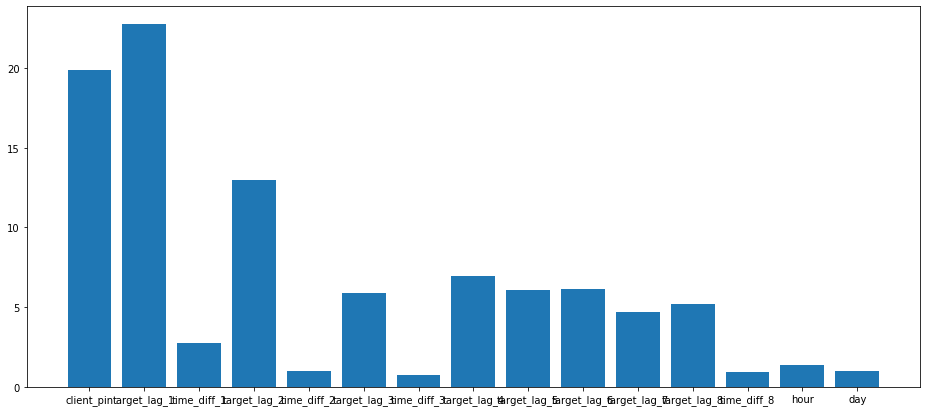

In [411]:
plt.figure(figsize=(16, 7))
plt.bar(X_test.columns[model.feature_importances_ > 0.7], model.feature_importances_[model.feature_importances_ > 0.7])
plt.show()

In [399]:
# # сохраняем модель
import joblib
joblib.dump(value=model, filename='catboost_model_3.pkl')

['catboost_model_2.pkl']

In [428]:
# print('F1 на обучении:', 
#         round(f1_score(
#             y_true=y_train,
#             y_pred=model.predict(X_train),
#             average='macro'
#         ), 3)
#      )
print('F1 на валидации:', 
        round(f1_score(
            y_true=y_val,
            y_pred=model.predict(X_val),
            average='macro'
        ), 3)
     )

F1 на валидации: 0.381


In [400]:
sample_sub['client_pin'] = X_test.client_pin.values
sample_sub['prediction'] = model.predict(X_test)

In [401]:
sample_sub.to_csv('alfaboosters_3.csv', index=False)